In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

In [293]:
gdf_zones = gpd.read_file('../charger_network_analysis/Data/NGOD/Shapes/V2_Zones.shp')

gdf_zones['in_california'] = gdf_zones['V2ZONEID'].apply(lambda zid: 'CA' in zid)

gdf_zones_california = gdf_zones[gdf_zones['in_california']]

gdf_zones_california = gdf_zones_california.explode(drop = True)

In [250]:
# Loading Info


graph = src.graph.graph_from_json('graph.json')

In [183]:
graph.nodes[176427]

{'status': 1,
 'visited': 0,
 'name': 'VCH MOB EV3',
 'address': '41169 Goodwin Way',
 'city': 'Madera',
 'state': 'CA',
 'zip': 93636,
 'x': -119.799034,
 'y': 36.886757,
 'dcfc': 0,
 'ev_network_clean': 'ChargePoint Network',
 'n_ac': 2.0,
 'n_dc': nan,
 'rural': 1.0}

In [184]:
np.nanmax([np.nan, 0])

0.0

In [259]:
deep_reload(src)

parameters_sr = json.load(open('CEC/parameters_cec_router_short_routes.json', 'rb'))

cases_sr = src.router.produce_routing_inputs(graph, parameters_sr, tt = 300)

In [286]:
deep_reload(src)

cases = cases_sr

final_routes = []

for key in src.progress_bar.ProgressBar(list(cases.keys()), end_color = ''):

    # try:

    case = cases[key]

    raw_routes, raw_route_weights, success = src.router.router(case)

    routes = src.router.route_information(graph, raw_routes, parameters['route_fields'])

    full_routes = []
    
    for idx, route in enumerate(routes):

        if len(route['nodes']) > 3:
    
            route['vehicle'] = case['information']['vehicle']
            route['depot'] = case['information']['depot']
            route['km'] = raw_route_weights[idx][0] / 1000
            route['hours'] = raw_route_weights[idx][1] / 3600
    
            full_routes.append(route)

    final_routes.extend(full_routes)

    # except:
    
    #     pass

 [------------->] (12/12) 100.00%, 1.41 it/s, 9.25 s elapsed, 0.00 s remaining

In [300]:
n_routes = len(final_routes)
stations = np.array([len(r['nodes']) for r in final_routes])
chargers = np.array([sum(r['chargers']) for r in final_routes])
hours = np.array([r['hours'] for r in final_routes])
nodes_visited = np.unique(np.concatenate([r['nodes'] for r in final_routes]))
            
n_routes, sum(stations), sum(chargers), sum(hours)

(190, 807, 1079.0, 632.7869661906815)

In [347]:
807/190, 1097/190, 633/190, 633/807, 633/1079

(4.247368421052632,
 5.773684210526316,
 3.331578947368421,
 0.7843866171003717,
 0.5866543095458758)

[Text(0.5, 0, 'Route Stops'), Text(0, 0.5, 'Number of Routes')]

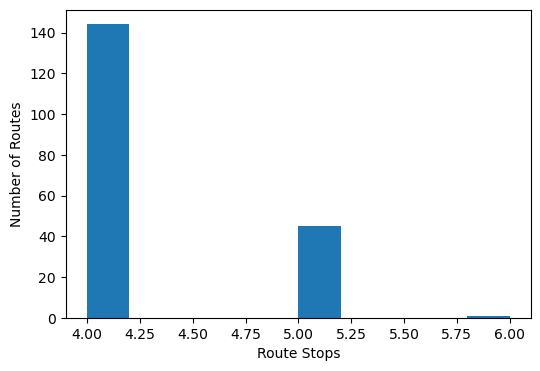

In [292]:
fig, ax = plt.subplots(figsize = (6, 4))

ax.hist(stations)

ax.set(**{
    'xlabel': 'Route Stops',
    'ylabel': 'Number of Routes',
})

(array([0.    , 0.3333, 0.6666, 0.9999,    nan]), array([ 239,   93,   83,   14, 1574]))
(array([0.    , 0.9999]), array([2000,    3]))


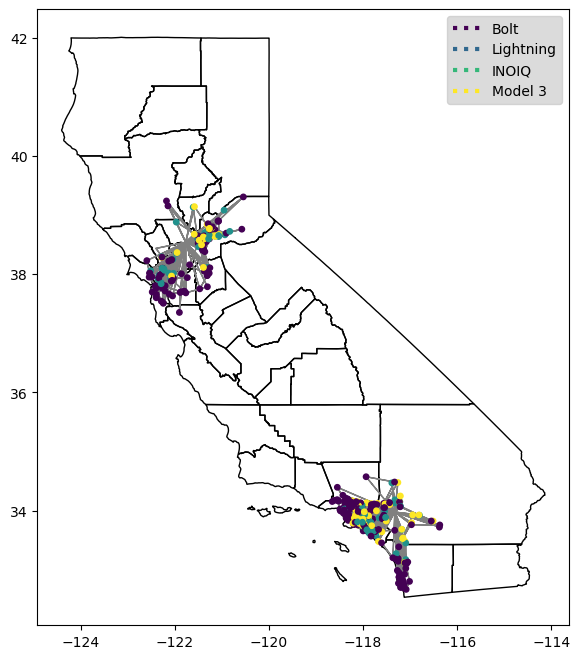

In [324]:
deep_reload(src)

routes = final_routes

node_to_idx, idx_to_node = src.router.assignments(list(graph.nodes))

raw_routes = [[node_to_idx[n] for n in r['nodes']] for r in routes]

for node, info in graph._node.items():
    info['route_depot'] = 0
    if node >= 1000000000:
        info['is_depot'] = True
    else:
        info['is_depot'] = False

for route in routes:
    # print(route['vehicle'])
    if 'Bolt' in route['vehicle']:
        vn = 0

    elif 'Lightning' in route['vehicle']:
        vn = 1/3

    elif 'IONIQ' in route['vehicle']:
        vn = 2/3

    elif 'Model' in route['vehicle']:
        vn = 3/3
    else:
        vn = 0
    # print(vn)
    for n in route['nodes']:
        graph._node[n]['route_depot'] = vn

for node, info in graph._node.items():

    if node not in nodes_visited:

        graph._node[node]['route_depot'] = np.nan

arrow_kwargs = {
    'color': 'gray',
    'zorder': 0,
}

depot_kwargs = {
    'marker': 'h',
    's': 200,
    # 'c': 'k',
}

destination_kwargs = {
    's': 15,
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)

src.figures.PlotRoutes(graph, raw_routes, ax = ax,
                       arrow_kwargs = arrow_kwargs,
                       depot_kwargs = depot_kwargs,
                       destination_kwargs = destination_kwargs,
                      )
from matplotlib.lines import Line2D

colors = src.figures.ReturnColorMap('viridis')(np.array([0, 1/3, 2/3, 1]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='dotted') for c in colors]
labels = ['Bolt', 'Lightning', 'INOIQ', 'Model 3']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)
# src.figures.PlotGraph(src.graph.subgraph(graph, [1000000000, 2000000000, 3000000000]), ax = ax)

In [326]:
deep_reload(src)

parameters_rr = json.load(open('CEC/parameters_cec_router_regular_routes.json', 'rb'))

cases_rr = src.router.produce_routing_inputs(graph, parameters_rr, tt = 300)

In [328]:
deep_reload(src)

cases = cases_rr

final_routes = []

for key in src.progress_bar.ProgressBar(list(cases.keys()), end_color = ''):

    # try:

    case = cases[key]

    raw_routes, raw_route_weights, success = src.router.router(case)

    routes = src.router.route_information(graph, raw_routes, parameters['route_fields'])

    full_routes = []
    
    for idx, route in enumerate(routes):

        if len(route['nodes']) > 3:
    
            route['vehicle'] = case['information']['vehicle']
            route['depot'] = case['information']['depot']
            route['km'] = raw_route_weights[idx][0] / 1000
            route['hours'] = raw_route_weights[idx][1] / 3600
    
            full_routes.append(route)

    final_routes.extend(full_routes)

    # except:
    
    #     pass

 [------------->] (12/12) 100.00%, 1.92 it/s, 6.76 s elapsed, 0.00 s remaining

In [329]:
n_routes = len(final_routes)
stations = np.array([len(r['nodes']) for r in final_routes])
chargers = np.array([sum(r['chargers']) for r in final_routes])
hours = np.array([r['hours'] for r in final_routes])
nodes_visited = np.unique(np.concatenate([r['nodes'] for r in final_routes]))
            
n_routes, sum(stations), sum(chargers), sum(hours)

(246, 1612, 3813.0, 1653.2763441176355)

In [348]:
1612/246, 3813/246, 1653/1612, 1653/3813

(6.5528455284552845, 15.5, 1.0254342431761787, 0.43351691581431945)

[Text(0.5, 0, 'Route Stops'), Text(0, 0.5, 'Number of Routes')]

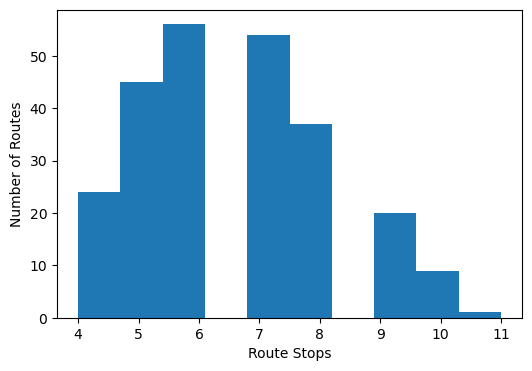

In [330]:
fig, ax = plt.subplots(figsize = (6, 4))

ax.hist(stations)

ax.set(**{
    'xlabel': 'Route Stops',
    'ylabel': 'Number of Routes',
})

(array([0.    , 0.3333, 0.6666, 0.9999,    nan]), array([346, 349, 296, 132, 880]))
(array([0.    , 0.9999]), array([2000,    3]))


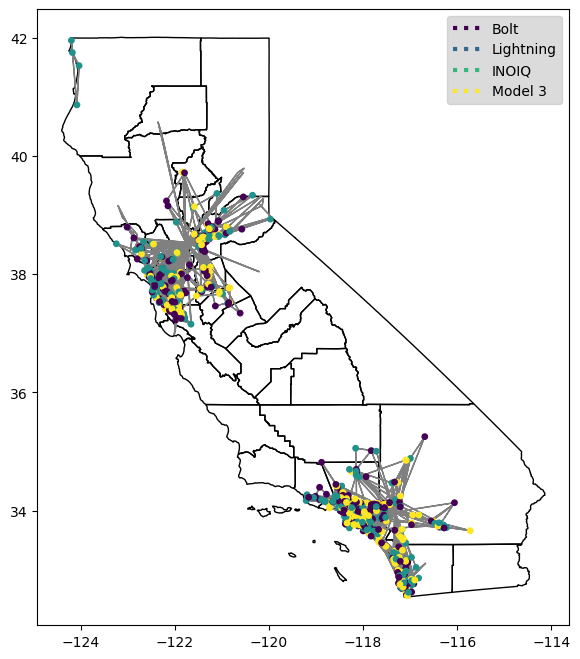

In [331]:
deep_reload(src)

routes = final_routes

node_to_idx, idx_to_node = src.router.assignments(list(graph.nodes))

raw_routes = [[node_to_idx[n] for n in r['nodes']] for r in routes]

for node, info in graph._node.items():
    info['route_depot'] = 0
    if node >= 1000000000:
        info['is_depot'] = True
    else:
        info['is_depot'] = False

for route in routes:
    # print(route['vehicle'])
    if 'Bolt' in route['vehicle']:
        vn = 0

    elif 'Lightning' in route['vehicle']:
        vn = 1/3

    elif 'IONIQ' in route['vehicle']:
        vn = 2/3

    elif 'Model' in route['vehicle']:
        vn = 3/3
    else:
        vn = 0
    # print(vn)
    for n in route['nodes']:
        graph._node[n]['route_depot'] = vn

for node, info in graph._node.items():

    if node not in nodes_visited:

        graph._node[node]['route_depot'] = np.nan

arrow_kwargs = {
    'color': 'gray',
    'zorder': 0,
}

depot_kwargs = {
    'marker': 'h',
    's': 200,
    # 'c': 'k',
}

destination_kwargs = {
    's': 15,
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)

src.figures.PlotRoutes(graph, raw_routes, ax = ax,
                       arrow_kwargs = arrow_kwargs,
                       depot_kwargs = depot_kwargs,
                       destination_kwargs = destination_kwargs,
                      )
from matplotlib.lines import Line2D

colors = src.figures.ReturnColorMap('viridis')(np.array([0, 1/3, 2/3, 1]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='dotted') for c in colors]
labels = ['Bolt', 'Lightning', 'INOIQ', 'Model 3']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)
# src.figures.PlotGraph(src.graph.subgraph(graph, [1000000000, 2000000000, 3000000000]), ax = ax)

In [332]:
deep_reload(src)

parameters_lr = json.load(open('CEC/parameters_cec_router_long_routes.json', 'rb'))

cases_lr = src.router.produce_routing_inputs(graph, parameters_lr, tt = 300)

In [333]:
deep_reload(src)

cases = cases_lr

final_routes = []

for key in src.progress_bar.ProgressBar(list(cases.keys()), end_color = ''):

    # try:

    case = cases[key]

    raw_routes, raw_route_weights, success = src.router.router(case)

    routes = src.router.route_information(graph, raw_routes, parameters['route_fields'])

    full_routes = []
    
    for idx, route in enumerate(routes):

        if len(route['nodes']) > 3:
    
            route['vehicle'] = case['information']['vehicle']
            route['depot'] = case['information']['depot']
            route['km'] = raw_route_weights[idx][0] / 1000
            route['hours'] = raw_route_weights[idx][1] / 3600
    
            full_routes.append(route)

    final_routes.extend(full_routes)

    # except:
    
    #     pass

 [------------->] (12/12) 100.00%, 2.27 it/s, 5.74 s elapsed, 0.00 s remaining

In [334]:
n_routes = len(final_routes)
stations = np.array([len(r['nodes']) for r in final_routes])
chargers = np.array([sum(r['chargers']) for r in final_routes])
hours = np.array([r['hours'] for r in final_routes])
nodes_visited = np.unique(np.concatenate([r['nodes'] for r in final_routes]))
            
n_routes, sum(stations), sum(chargers), sum(hours)

(102, 1565, 4839.0, 1880.7437179213084)

In [350]:
1565/102, 4839/102, 1881/1565, 1881/4839

(15.343137254901961,
 47.44117647058823,
 1.2019169329073482,
 0.38871667699938006)

[Text(0.5, 0, 'Route Stops'), Text(0, 0.5, 'Number of Routes')]

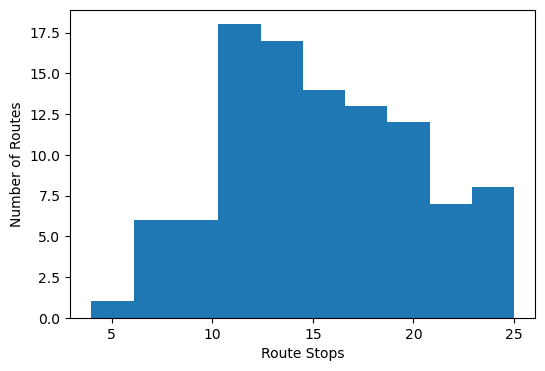

In [335]:
fig, ax = plt.subplots(figsize = (6, 4))

ax.hist(stations)

ax.set(**{
    'xlabel': 'Route Stops',
    'ylabel': 'Number of Routes',
})

(array([0.    , 0.3333, 0.6666,    nan]), array([ 366,  149,   46, 1442]))
(array([0.    , 0.9999]), array([2000,    3]))


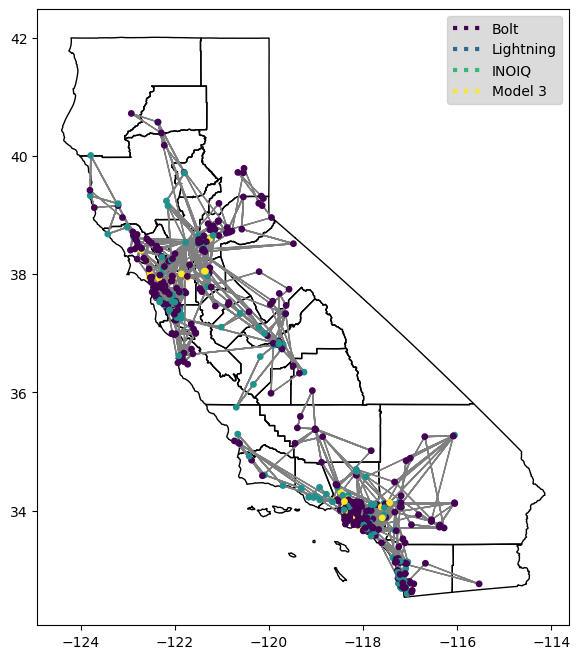

In [346]:
deep_reload(src)

routes = np.random.choice(final_routes, len(final_routes), replace = False)

node_to_idx, idx_to_node = src.router.assignments(list(graph.nodes))

raw_routes = [[node_to_idx[n] for n in r['nodes']] for r in routes]

for node, info in graph._node.items():
    info['route_depot'] = 0
    if node >= 1000000000:
        info['is_depot'] = True
    else:
        info['is_depot'] = False

for route in routes:
    # print(route['vehicle'])
    if 'Bolt' in route['vehicle']:
        vn = 0

    elif 'Lightning' in route['vehicle']:
        vn = 1/3

    elif 'IONIQ' in route['vehicle']:
        vn = 2/3

    elif 'Model' in route['vehicle']:
        vn = 0
    else:
        vn = 0
    # print(vn)
    for n in route['nodes']:
        graph._node[n]['route_depot'] = vn

for node, info in graph._node.items():

    if node not in nodes_visited:

        graph._node[node]['route_depot'] = np.nan

arrow_kwargs = {
    'color': 'gray',
    'zorder': 0,
}

depot_kwargs = {
    'marker': 'h',
    's': 200,
    # 'c': 'k',
}

destination_kwargs = {
    's': 15,
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)

src.figures.PlotRoutes(graph, raw_routes, ax = ax,
                       arrow_kwargs = arrow_kwargs,
                       depot_kwargs = depot_kwargs,
                       destination_kwargs = destination_kwargs,
                      )
from matplotlib.lines import Line2D

colors = src.figures.ReturnColorMap('viridis')(np.array([0, 1/3, 2/3, 1]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='dotted') for c in colors]
labels = ['Bolt', 'Lightning', 'INOIQ', 'Model 3']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)
# src.figures.PlotGraph(src.graph.subgraph(graph, [1000000000, 2000000000, 3000000000]), ax = ax)

In [345]:
np.random.choice(final_routes, len(final_routes), replace = False)[0]

{'Station Name': ['UC Riverside Depot',
  'Via Verde Park & Ride',
  '22028 Collins St',
  'CAMARILLO LIBRARY 13',
  'CSG EV SB STATION 2',
  'MUSTANG VILLAGE CHARGEPOINT 2',
  'Pismo Beach Premium Outlets',
  'BMW SANTA MARIA BMWSM LEVEL 2',
  'CHUMASH SANTAYNEZMAIN1',
  'Lake Casitas Municipal Water District - Recreational Area',
  'DCH Audi - Oxnard',
  'Bunnin Chevrolet of Fillmore',
  'First Nissan',
  "Kohl's Thousand Oaks",
  'LFT-CALABASAS # 2',
  'CAMARILLO CITY HALL 7&8',
  'Calabasas Civic Center',
  '13631 Van Nuys Blvd',
  'SANTA MONICA LOT 8',
  '10UCP PRKG LVL 5 - J',
  'UC Riverside Depot'],
 'City': ['Riverside',
  'San Dimas',
  'Los Angeles',
  'Camarillo',
  'Santa Barbara',
  'San Luis Obispo',
  'Pismo Beach',
  'Santa Maria',
  'Santa Ynez',
  'Ventura',
  'Oxnard',
  'Fillmore',
  'Simi Valley',
  'Newbury Park',
  'Calabasas',
  'Camarillo',
  'Calabasas',
  'Los Angeles',
  'Santa Monica',
  'Los Angeles',
  'Riverside'],
 'State': ['CA',
  'CA',
  'CA',
  'CA